***STAGE 2: DATA PRE-PROCESSING***

# **1. Import Libraries**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats

In [54]:
import matplotlib

print(matplotlib.__version__)
print(sns.__version__)
print(pd.__version__)

3.2.2
0.11.2
1.3.5


# **2. Load Data** <br>
Data yang digunakan yaitu [Used Car Auction Prices](https://www.kaggle.com/datasets/tunguz/used-car-auction-prices) dari kaggle.com.


In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/car_prices.csv', on_bad_lines='skip')

# **3. Data Pre-processing** <br>

## 3.1. Handling Duplicated Data

In [57]:
df.duplicated().sum()

0

Tidak ada data duplikat.

## 3.2. Handling Missing Values

### 3.2.1 Drop Missing Values

In [58]:
mv = df.isnull().sum()
tmv = df.isnull().count()

pmv = mv*100/tmv

mdf = pd.concat([mv, pmv], axis=1)
mdf.columns = ['Missing Value Total', 'Missing Value Percentage (%)']
mdf.reset_index(inplace=True)
# mdf

In [59]:
col_mv = mdf[mdf['Missing Value Percentage (%)'] < 2.5]['index'] # kolom dengan missing value < 2.5 akan kita drop barisnya
# col_mv

In [60]:
# Setelah drop missing value dari kolom yang persentase missing value < 2.5 %
cols = col_mv.values
for i in cols:
  df = df[~(df[i].isnull())]
df.isna().sum()

year                0
make                0
model               0
trim                0
body                0
transmission    61324
vin                 0
state               0
condition           0
odometer            0
color               0
interior            0
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [61]:
# df.shape

### 3.2.2 Fill Missing Value in Transmission Column

In [62]:
# before filling missing value
df['transmission'].isnull().sum()

61324

In [63]:
# after filling missing value
df['transmission'] = df['transmission'].fillna(df['transmission'].mode()[0])
df['transmission'].isnull().sum()

0

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 533660 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          533660 non-null  int64  
 1   make          533660 non-null  object 
 2   model         533660 non-null  object 
 3   trim          533660 non-null  object 
 4   body          533660 non-null  object 
 5   transmission  533660 non-null  object 
 6   vin           533660 non-null  object 
 7   state         533660 non-null  object 
 8   condition     533660 non-null  float64
 9   odometer      533660 non-null  float64
 10  color         533660 non-null  object 
 11  interior      533660 non-null  object 
 12  seller        533660 non-null  object 
 13  mmr           533660 non-null  int64  
 14  sellingprice  533660 non-null  int64  
 15  saledate      533660 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 69.2+ MB


## 3.3. Recategorization High Cardinality in Categorical Features

### 3.3.1 Color

In [65]:
# mengganti nilai - menjadi unknown pada kolom color
df.color = df.color.replace('—', 'unknown')

In [66]:
color_grouped = df.groupby('color').agg({'sellingprice':'count'}).reset_index()
color_grouped['Percentage']=color_grouped['sellingprice']*100/color_grouped.sellingprice.sum()
# color_grouped.sort_values('sellingprice', ascending=False).reset_index(drop=True)

melihat persentase dibawah 10 yang kecil, oleh karena itu beberapa warna yang di rasa sama akan digabungkan.

In [67]:
def color_category(x): 
  if x in ['black','charcoal','unknown']: 
    color = 'black'
  elif x in ['off-white', 'white']:
    color = 'white'
  elif x == 'silver':
    color = 'silver'
  elif x == 'gray':
    color = 'gray'
  elif x in ['blue', 'turqoise']:
    color = 'blue'
  elif x in ['burgundy', 'red', 'purple']:
    color = 'red'
  elif x in ['beige','brown']:
    color = 'brown'
  elif x == 'green':
    color = 'green'
  elif x in ['gold','yellow']:
    color = 'gold'
  elif x == 'pink':
    color = 'pink'
  else:
    color= 'orange'
  return color

In [68]:
# Membuat kolom baru yaitu kolom color_new menggunakan fungsi color_category
df['color_new'] = df['color'].apply(lambda x: color_category(x))

In [69]:
# # KDE color_new vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='color_new', common_norm=False)

# Drop kolom color
df = df.drop(columns='color')

### 3.3.2 Interior

In [70]:
#df.groupby('interior')['interior'].count().sort_values(ascending=False)

In [71]:
# Mengganti nilai - menjadi unknown pada kolom interior
df.interior = df.interior.replace('—', 'unknown')

In [72]:
# membuat kolom baru yaitu kolom interior_new menggunakan fungsi interior_category
df['interior_new'] = df['interior'].apply(lambda x: color_category(x))

In [73]:
# # KDE interior_new vs sellingprice
# plt.figure(figsize=(16, 8))
# sns.kdeplot(data=df, x='sellingprice', hue='interior_new', common_norm=False, palette="bright")

# Drop kolom interior
df = df.drop(columns='interior')

## 3.4. Feature Transformation <br>
Log Transformation pada feature odometer. Kami melakukan transoformasi terlebih dulu sebelum melakukan handling outlier. Jika kita melakukan handling outlier terlebih dulu, maka kemungkinan data yang akan dibuang lebih banyak. Oleh karena itu, kami melakukan log transformation terlebih dulu dengan harapan data semakin terdistribusi dengan normal sehingga data yang terindikasi outlier lebih sedikit.

In [74]:
# # KDE sebelum transformation
# cols = ['odometer']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

### 3.4.1 Transformasi dengan Pangkat 1/3

In [75]:
df['odometer_pow'] = df['odometer'].apply(lambda x : x**(1/3))
print('Skew value:', df['odometer_pow'].skew())

# # KDE setelah transformation dengan pangkat 1/3
# cols = ['odometer_pow']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.0656155379397687


### 3.4.2 PowerTransformer <br>
[PowerTransformer](https://medium.com/towards-data-science/how-to-differentiate-between-scaling-normalization-and-log-transformations-69873d365a94)

In [76]:
# Transformasi dengan PowerTransformer
from sklearn.preprocessing import PowerTransformer
df['odometer_pt'] = PowerTransformer().fit_transform(df['odometer'].values.reshape(len(df), 1))
print('Skew value:', df['odometer_pt'].skew())

# # KDE setelah Transformasi dengan PowerTransformer
# cols = ['odometer_pt']

# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.012277500663525181


Berdasarkan nilai skew, kami memilih menggunakan hasil transformasi dari PowerTransformer (odometer_pt)

In [77]:
# Drop kolom odometer_pow
df = df.drop(columns='odometer_pow')

## 3.5. Handling Outliers <br>
Handling outlier dilakukan pada kolom `odometer_pt` dan `sellingprice`.

In [78]:
# Boxplot sebelum handling outlier
cols = ['odometer_pt', 'sellingprice']

# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

rows_before_filt = len(df)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')

Jumlah Baris sebelum filter: 533660 



In [79]:
# Handling outlier dengan z-score
cols = ['odometer_pt', 'sellingprice']

filtered_entries = np.array([True] * len(df))

for col in cols:
    zscore = abs(stats.zscore(df[col]))                       # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries        # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries]                                     # filter, cuma ambil yang z-scorenya dibawah 3

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah baris setelah memfilter outlier: 525058
Persentase outlier yang dibuang: 1.61


In [80]:
# # Boxplot setelah PowerTransformer dan handlingoutlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(9,6))
# for i in range(len(cols)):
#     plt.subplot(1, len(cols), i+1)
#     sns.boxplot(y = df[cols[i]], orient = 'v')
#     plt.tight_layout()

In [81]:
# # KDE odometer_pt dan sellingprice setelah handling outlier
# cols = ['odometer_pt', 'sellingprice']
# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(3, 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

## 3.6. Feature Extraction <br>


### 3.6.1 New Column: Car Age

In [82]:
# Format awal kolom saledate
print('format saledate original:\n', df.saledate[0])

# Transform kolom saledate
df['saledate'] = df['saledate'].apply(lambda x:re.search('(\w+\s\d{2}\s\d{4})',x).group(1))
df['saledate'] = pd.to_datetime(df['saledate'], format='%b %d %Y')

format saledate original:
 Tue Dec 16 2014 12:30:00 GMT-0800 (PST)


In [83]:
# Buat kolom baru saledate_year
df['saledate_year'] = df['saledate'].dt.year

# Buat kolom baru Car Age (Car age = saledate_year - year <tahun produksi mobil>)
df['car_age'] = df['saledate_year'] - df['year']
print('Unique value car age:', df['car_age'].unique())

Unique value car age: [-1  1  0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 17 20 22 23
 21 24 25]


In [84]:
# Drop baris yang mengandung nilai < 0 pada kolom Car Age (terdapat 141 baris yg car age < 0)
df = df[df['car_age'] >= 0]

# Drop kolom saledate dan year
df = df.drop(columns=['saledate', 'year'])

In [85]:
# PowerTransform Car Age
df['car_age_pt'] = PowerTransformer().fit_transform(df['car_age'].values.reshape(len(df), 1))
print('Skew value:', df['car_age_pt'].skew())

# # KDE car_age
# cols = ['car_age', 'car_age_pt']
# plt.figure(figsize=(8, 6))
# for i in range(len(cols)):
#   plt.subplot(len(cols), 1, i+1)
#   sns.histplot(data=df, x=df[cols[i]], kde=True)
#   plt.tight_layout()

Skew value: 0.005011404205303489


In [86]:
# Drop car age
df = df.drop(columns='car_age')

## 3.7. Feature Selection <br>
Feature yang akan digunakan dalam membangun model adalah:
- **Categorical**: color_new, interior_new, model, transmission
- **Numerical**: car_age_pt, odometer_pt, condition.
- Kolom yang **di-drop**:
  - year -> kolom ini digantikan dengan kolom car_age
  - trim, vin -> karena high cardinality
  - make, body -> unique terhadap model
  - state -> karena KDE-nya sama-sama saja (?)
  - seller, mmr -> high cardinality
  - saledate -> high cardinality

KOLOM YANG PERLU DISTANDARISASI SETELAH SPLITTING:
car_age_pt, odometer_pt, condition

Karena terdapat banyak sekali data unique pada model, maka hanya digunakan 30 model teratas.

In [87]:
# Feature yang dipilih untuk memprediksi sellingprice
df = df[['color_new', 'interior_new', 'model', 'transmission',
         'car_age_pt', 'odometer_pt', 'condition', 'sellingprice']]

g_m = df.groupby('model')['transmission'].count()
g_m.sort_values(ascending=False, inplace=True)
g_m = g_m.reset_index()
g_m = g_m.iloc[:30, 0]

model_new = [i for i in g_m]

df = df[df['model'].isin(model_new)]
df.shape

(231478, 8)

## 3.8. Feature encoding

### 3.8.1 Label Encoding

In [88]:
# Label encoding -> kolom transmission
mapping_trans = {
    'automatic' : 0,
    'manual' : 1
}

df['transmission'] = df['transmission'].map(mapping_trans)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### 3.8.2 One Hot Encoding

In [89]:
# OHE -> kolom color_new, interior_new, make_new, body_new

cols_OHE = ['color_new', 'interior_new', 'model']

for i in cols_OHE:
    onehots = pd.get_dummies(df[i], prefix=i, drop_first=True)  # drop_first=True utk menghindari multicollinearity
    df = df.merge(onehots, how='outer', right_index = True, left_index = True)

### 3.8.3 Drop the columns that have been done Feature Encoding <br>
Kolom yang telah dilakukan OHE akan di-drop

In [90]:
df = df.drop(columns=cols_OHE)

## 3.9. All Features
- [split_data](https://towardsdatascience.com/how-to-split-a-dataset-into-training-and-testing-sets-b146b1649830)
- [Using StandarScaler() after split data](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data)
- https://scikit-learn.org/stable/common_pitfalls.html

In [91]:
df.head(2)

,transmission,car_age_pt,odometer_pt,condition,sellingprice,color_new_blue,color_new_brown,color_new_gold,color_new_gray,color_new_green,...,model_Jetta,model_Malibu,model_Maxima,model_Mustang,model_Rogue,model_Sentra,model_Silverado 1500,model_Sonata,model_Taurus,model_Town and Country
2,0,-1.306077,-2.604439,4.5,30000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,0,-2.422727,-0.673565,2.0,9800,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
df.columns

Index(['transmission', 'car_age_pt', 'odometer_pt', 'condition',
       'sellingprice', 'color_new_blue', 'color_new_brown', 'color_new_gold',
       'color_new_gray', 'color_new_green', 'color_new_orange',
       'color_new_pink', 'color_new_red', 'color_new_silver',
       'color_new_white', 'interior_new_blue', 'interior_new_brown',
       'interior_new_gold', 'interior_new_gray', 'interior_new_green',
       'interior_new_orange', 'interior_new_red', 'interior_new_silver',
       'interior_new_white', 'model_Accord', 'model_Altima', 'model_C-Class',
       'model_Camry', 'model_Civic', 'model_Corolla', 'model_Cruze',
       'model_Edge', 'model_Elantra', 'model_Equinox', 'model_Escape',
       'model_Explorer', 'model_F-150', 'model_Focus', 'model_Fusion',
       'model_G Sedan', 'model_Grand Caravan', 'model_Grand Cherokee',
       'model_Impala', 'model_Jetta', 'model_Malibu', 'model_Maxima',
       'model_Mustang', 'model_Rogue', 'model_Sentra', 'model_Silverado 1500',
       'm

In [93]:
df.shape

(231478, 53)

In [94]:
# Split Dataset
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.3, random_state=25)

print('Total training data:', training_data.shape[0])
print('Total testing data:', testing_data.shape[0])

Total training data: 162034
Total testing data: 69444


In [95]:
# Save to csv
training_data.to_csv('train_data.csv', index=False)
testing_data.to_csv('test_data.csv', index=False)

In [96]:
# Splitting data

X_train = training_data.drop(columns=['sellingprice'])
y_train =  training_data['sellingprice']

X_test = testing_data.drop(columns=['sellingprice'])
y_test = testing_data['sellingprice']

In [97]:
# Standarisasi Features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform (X_test)

In [98]:
# # Fitting simple linear regression to the Training Set
# from sklearn.ensemble import RandomForestClassifier as RF

# regressor = RF()
# regressor.fit(X_train, y_train)

In [99]:
# # Model Evaluation
#y_pred_train = regressor(X_train)
# y_pred_test = regressor(X_test)

# Modeling ML

## Linear Regression

In [103]:
from sklearn.model_selection import cross_val_score
def get_cv_scores(model):
    scores = cross_val_score(model,
                             X_train,
                             y_train,
                             cv=10,
                             scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))

In [104]:
from sklearn.linear_model import LinearRegression, Ridge
lr = LinearRegression()
lr.fit(X_train, y_train)
get_cv_scores(lr)

CV Mean:  0.816894687496583
STD:  0.0026100702911876893


In [106]:
y_pred = lr.predict(X_test)

In [107]:
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_compare.head()

,Actual,Predicted
115250,6200,2773.470038
437715,2500,3620.102708
35581,8600,10444.766233
152249,14200,13230.995697
304665,18000,18502.037182


In [108]:
# cek underfit / overfit
y_pred_train = lr.predict(X_train)

print("Train Score")
print('MAE:', round(mean_absolute_error(y_train, y_pred_train),2))
print('RMSE:', round(mean_squared_error(y_train, y_pred_train, squared=False),2))
print('R2 Score:', round(r2_score(y_train, y_pred_train),2))
print("================")
print("Test Score")
print('MAE:', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE:', round(mean_squared_error(y_test, y_pred, squared=False),2))
print('R2 Score :', round(r2_score(y_test, y_pred),2))

Train Score
MAE: 2105.37
RMSE: 2971.63
R2 Score: 0.82
Test Score
MAE: 2095.13
RMSE: 2958.44
R2 Score : 0.82


### Feature Importance

In [128]:
print("Intercept: ", lr.intercept_)
print("Coef (", len(lr.coef_), "): ", lr.coef_)

Intercept:  12925.30979917795
Coef ( 52 ):  [ 4.65726398e+01 -2.42227978e+03 -2.27704380e+03  1.34020363e+03
 -1.27533778e+02 -9.81476336e+01 -7.55662056e+01 -1.33376361e+02
 -7.48567403e+01 -1.15747976e+01  1.65757500e+00 -9.38559483e+01
 -1.66179930e+02 -1.70638929e+02  3.77312346e+00 -1.09439006e+02
 -1.05667607e+01 -5.20373424e+02 -1.67272411e+01 -1.45036394e+02
  1.59065287e+02 -4.43025241e+01  3.37670151e+01 -9.66110590e+02
 -2.08800255e+03 -9.21675810e+01 -1.37111715e+03 -1.13917911e+03
 -1.32127134e+03 -1.61773432e+03 -1.71041983e+02 -1.48732246e+03
 -7.51682213e+02 -1.13196047e+03  1.44084020e+02  4.72334397e+02
 -2.10887147e+03 -1.74379457e+03 -1.50366350e+02 -1.26996699e+03
  3.56438424e+01 -1.31913708e+03 -1.15256021e+03 -1.29592129e+03
 -6.21253372e+02 -7.04400013e+02 -8.17669835e+02 -1.39868921e+03
  2.00001335e+02 -1.27020844e+03 -7.89737900e+02 -7.52199112e+02]


In [153]:
df.columns

Index(['transmission', 'car_age_pt', 'odometer_pt', 'condition',
       'sellingprice', 'color_new_blue', 'color_new_brown', 'color_new_gold',
       'color_new_gray', 'color_new_green', 'color_new_orange',
       'color_new_pink', 'color_new_red', 'color_new_silver',
       'color_new_white', 'interior_new_blue', 'interior_new_brown',
       'interior_new_gold', 'interior_new_gray', 'interior_new_green',
       'interior_new_orange', 'interior_new_red', 'interior_new_silver',
       'interior_new_white', 'model_Accord', 'model_Altima', 'model_C-Class',
       'model_Camry', 'model_Civic', 'model_Corolla', 'model_Cruze',
       'model_Edge', 'model_Elantra', 'model_Equinox', 'model_Escape',
       'model_Explorer', 'model_F-150', 'model_Focus', 'model_Fusion',
       'model_G Sedan', 'model_Grand Caravan', 'model_Grand Cherokee',
       'model_Impala', 'model_Jetta', 'model_Malibu', 'model_Maxima',
       'model_Mustang', 'model_Rogue', 'model_Sentra', 'model_Silverado 1500',
       'm

In [154]:
# mapping coef dengan columnds
df_features = df.copy()
df_features = df_features.drop(columns=['sellingprice'])
df_f_list = df_features.columns.to_list()

df_fi = pd.DataFrame()
i = 0
li_feature = []
li_score = []
for n in df_f_list:
  li_feature.append(n)
  li_score.append(lr.coef_[i])
  i+=1

df_fi['feature'] = li_feature
df_fi['score'] = li_score

df_fi.sort_values('score', ascending=False).reset_index()

,index,feature,score
0,3,condition,1340.203631
1,35,model_F-150,472.334397
2,48,model_Silverado 1500,200.001335
3,20,interior_new_red,159.065287
4,34,model_Explorer,144.084020
5,0,transmission,46.572640
6,40,model_Grand Cherokee,35.643842
7,22,interior_new_white,33.767015
8,14,interior_new_blue,3.773123
9,10,color_new_pink,1.657575


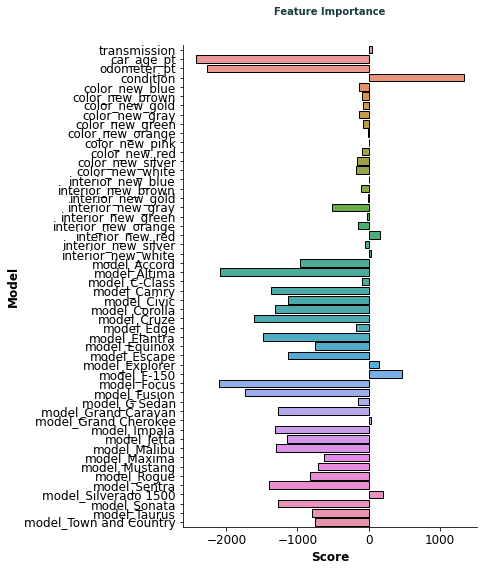

In [151]:
plt.figure(figsize=(7, 8))

# print(clrs)
sns.barplot(
    x='score', 
    y='feature', 
    data=df_fi, 
    orient='h',
    edgecolor='black')
sns.despine()

plt.title('Feature Importance', color='#1A3C40', fontsize=18, fontweight='bold', y=1.05)
plt.xlabel('Score', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.tight_layout()
plt.show()

### Regularization: Ridge

In [109]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [110]:
y_pred = ridge.predict(X_test)
y_pred_train = ridge.predict(X_train)

print("Train Score")
print('MAE:', round(mean_absolute_error(y_train, y_pred_train),2))
print('RMSE:', round(mean_squared_error(y_train, y_pred_train, squared=False),2))
print('R2 Score:', round(r2_score(y_train, y_pred_train),2))
print("================")
print("Test Score")
print('MAE:', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE:', round(mean_squared_error(y_test, y_pred, squared=False),2))
print('R2 Score :', round(r2_score(y_test, y_pred),2))

Train Score
MAE: 2105.36
RMSE: 2971.63
R2 Score: 0.82
Test Score
MAE: 2095.13
RMSE: 2958.44
R2 Score : 0.82


### Regularization: Ridge | Hyperparam Tuning

In [179]:
# Tuning Hyperparameter
# alpha = [0.001, 0.01, 0.1, 0.2, 0.3]
# alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
# alpha = [0, 1, 2, 3, 4, 5, 10]
alpha = [1.00000001, 1.0000001, 1.000001, 1.00001, 1.0001, 1.001]

solver = ['auto', 'svd', 'cholesky']
hyperparameter = dict(alpha = alpha, solver = solver)

ridge = Ridge(random_state=42)
rs = RandomizedSearchCV(ridge, hyperparameter, cv=5, scoring='r2', random_state=42)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(random_state=42),
                   param_distributions={'alpha': [1.00000001, 1.0000001,
                                                  1.000001, 1.00001, 1.0001,
                                                  1.001],
                                        'solver': ['auto', 'svd', 'cholesky']},
                   random_state=42, scoring='r2')

In [180]:
print('Best Alpha: ' + str(rs.best_estimator_.get_params()['alpha']))
print('Best Solver: ' + str(rs.best_estimator_.get_params()['solver']))

Best Alpha: 1.00000001
Best Solver: auto


In [181]:
y_pred = rs.predict(X_test)
y_pred_train = rs.predict(X_train)

print("Train Score")
print('MAE:', round(mean_absolute_error(y_train, y_pred_train),2))
print('RMSE:', round(mean_squared_error(y_train, y_pred_train, squared=False),2))
print('R2 Score:', round(r2_score(y_train, y_pred_train),2))
print("================")
print("Test Score")
print('MAE:', round(mean_absolute_error(y_test, y_pred),2))
print('RMSE:', round(mean_squared_error(y_test, y_pred, squared=False),2))
print('R2 Score :', round(r2_score(y_test, y_pred),2))

Train Score
MAE: 2105.36
RMSE: 2971.63
R2 Score: 0.82
Test Score
MAE: 2095.13
RMSE: 2958.44
R2 Score : 0.82
